## 4. Алгоритмы восстановления пробелов в тексте

In [5]:
import numpy as np
import pandas as pd
import operator

# Corus - NLP datasets
import corus
from corus import load_lenta

#NLTK - Natural Language Tool Kit
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import bigrams
from nltk import ngrams

#Other
from collections import Counter
import re
import string
from tqdm import notebook

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aptmess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aptmess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/aptmess/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/aptmess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from corus.sources.meta import METAS
from corus.readme import format_metas, show_html, patch_readme

html = format_metas(METAS)
show_html(html)

Dataset,API from corus import,Tags,Texts,Uncompressed,Description
Lenta.ru,load_lenta,news,739 351,1.66 Gb,wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz
Lib.rus.ec,load_librusec,fiction,301 871,144.92 Gb,Dump of lib.rus.ec prepared for RUSSE workshop wget http://panchenko.me/data/russe/librusec_fb2.plain.gz
Rossiya Segodnya,load_ria_raw load_ria,news,1 003 869,3.70 Gb,wget https://github.com/RossiyaSegodnya/ria_news_dataset/raw/master/ria.json.gz
Mokoron Russian Twitter Corpus,load_mokoron,social sentiment,17 633 417,1.86 Gb,Russian Twitter sentiment markup Manually download https://www.dropbox.com/s/9egqjszeicki4ho/db.sql
Wikipedia,load_wiki,,1 541 401,12.94 Gb,Russian Wiki dump wget https://dumps.wikimedia.org/ruwiki/latest/ruwiki-latest-pages-articles.xml.bz2
GramEval2020,load_gramru,,162 372,30.04 Mb,wget https://github.com/dialogue-evaluation/GramEval2020/archive/master.zip unzip master.zip mv GramEval2020-master/dataTrain train mv GramEval2020-master/dataOpenTest dev rm -r master.zip GramEval2020-master wget https://github.com/AlexeySorokin/GramEval2020/raw/master/data/GramEval_private_test.conllu
OpenCorpora,load_corpora,morph,4 030,20.21 Mb,wget http://opencorpora.org/files/export/annot/annot.opcorpora.xml.zip
RusVectores SimLex-965,load_simlex,emb sim,,,wget https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv wget https://rusvectores.org/static/testsets/ru_simlex965.tsv
Omnia Russica,load_omnia,morph web fiction,,489.62 Gb,"Taiga + Wiki + Araneum. Read ""Even larger Russian corpus"" https://events.spbu.ru/eventsContent/events/2019/corpora/corp_sborn.pdf Manually download http://bit.ly/2ZT4BY9"
factRuEval-2016,load_factru,ner news,254,969.27 Kb,"Manual PER, LOC, ORG markup prepared for 2016 Dialog competition wget https://github.com/dialogue-evaluation/factRuEval-2016/archive/master.zip unzip master.zip rm master.zip"


Задача *сегментации текста* возникает в различных прикладных задах, например, в задаче исправления опечаток в тексте пользователя, при анализе хештэгов в социальных сетях и т.д. Хэштеги идут без пробелов и не всегда можно понять - что именно содержится на изображении. Таким образом мы улучшаем

В качестве примера рассмотрим строку:

```python
test_string = tableapplecharitablecupboarding
```

Можно заметить, что расставить пробелы в данном случае можно четырьмя различными способами:

```python
s1 = {table, apple, char, it, able, cup, boar, ding}
s2 = {table, apple, char, it, able, cup, boarding}
s3 = {table, apple, charitable, cup, boar, ding}
s4 = {table, apple, charitable, cup, boarding}
```

Таким образом необходимо разработать алгоритмы, которые позволяют восстановить пробелы в тексте.

Скачаем тексты газеты `lenta.ru`

```bash
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz
```

In [7]:
def text_prepare(text, language='russian', delete_stop_words=False):
    """
        text: a string
        
        return: modified string
    """
    lemmatizer = WordNetLemmatizer()

    # 1. Перевести символы в нижний регистр
    text = text.lower() #your code
    
    # 2.1 Заменить символы пунктуации на пробелы
    text = re.sub(r'[{}]'.format(string.punctuation), ' ', text)
    
    
    
    # 2.2 Удалить "плохие" символы
    text = re.sub('[^A-Za-z0-9]' if language == 'english' else '[^А-яа-я]', ' ', text)

    
    # 3. Применить WordNetLemmatizer
    word_list = nltk.word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    # 4. Удалить стопслова.
    if delete_stop_words:
        stopWords = set(stopwords.words(language))
        for stopWord in stopWords:
            text = re.sub(r'\b{}\b'.format(stopWord), '', text)
        
    # 5. Удаляю пробелы у получая просто строку слов через пробел
    text = ' '.join(text.split())
    
    return text


def get_grams_from_text(path='lenta-ru-news.csv.gz', 
                        n=2, 
                        amount_of_sentense=1000, 
                        verbose=True, 
                        show_how_much=1000, **kwargs):
    records = load_lenta(path)
    grams, count = {}, 1
    flatten = lambda l: [' '.join(item) for sublist in l for item in sublist]
    try:
        while True and count != amount_of_sentense:
            item = next(records).text
            if verbose:
                print(f'Sentence {count}') if count % show_how_much == 0 else 'pass'
            
            for i in np.arange(1, n+1):
                if i not in list(grams.keys()):
                    grams[i] = Counter()
                ngram = [list(ngrams(text_prepare(sentense, **kwargs).lower().split(), n=i)) for sentense in nltk.sent_tokenize(item)]
                grams[i] += Counter(flatten(ngram))
            count +=1
    except StopIteration:
        pass
    finally:
        del records
    return grams


def predict(corpus, sentence, n=3):
    sen = text_prepare(sentence)
    cor = corpus.copy()
    rev = sen.split()[::-1]
    s = sum(list(cor[2].values()))
    s1 = sum(list(cor[1].values()))
    d = {}
    for key, value in list(cor[1].items()):
        a = []
        for i in np.arange(1, n+1):
            v = cor[2][f'{rev[i-1]} {key}']
            a.append(np.log(v / s) if v!=0 else np.log(0.000001))
        d[key] = sum([np.log(value / s1)] + a)    
    return sentence + ' ' + max(d.items(), key=operator.itemgetter(1))[0]

In [8]:
g = get_grams_from_text(n=1, 
                        amount_of_sentense=20000, 
                        show_how_much=5000, 
                        delete_stop_words=False)

Sentence 5000
Sentence 10000
Sentence 15000


In [9]:
russian_language_words_dict = list(g[1].keys())

## 4.1. Алгоритмы на основе корпуса слов

Под корпусом слов подразумевается заранее определенный словарь известных слов, которые могут встретиться в тексте.

Суть представленных ниже алгоритмов состоит в том, чтобы, проходя последовательно по тексту, найти наилучшую последовательность слов внутри строки.

### 4.1.1. Алгоритм максимального соответствия (`MaximalMatching`)

**Алгоритм максимального соответствия** -  это *жадный алгоритм*, в котором в тексте последовательно выделяются слова **наибольшей длины**, которые встретились в словаре. В качестве примера приведем строку:

```python
themendinehere - > the men dine here
```

Данную строку также можно разбить несколькими способами. На графе ниже приведены все возможные варианты разбиения:

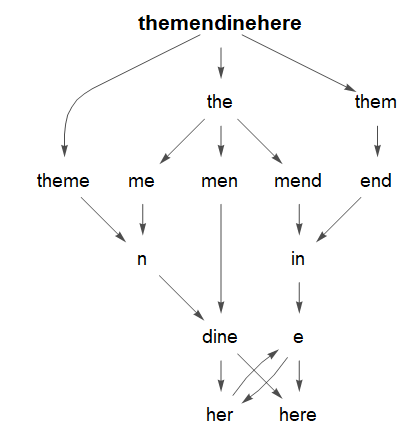

Тогда по данному методу получится строка:

```python
themendinehere - > theme n dine here
```

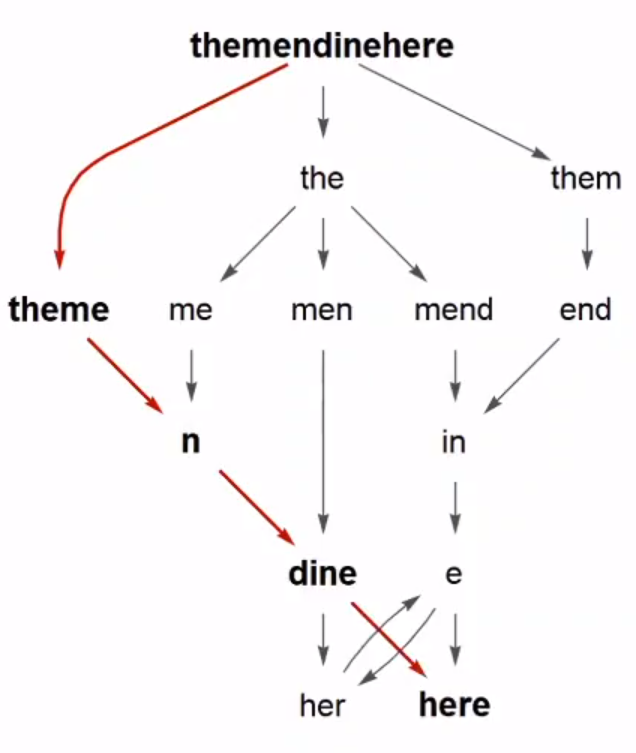

**Реализация алгоритма**:

In [11]:
string = "вицепремьерноваядомашняярыба"
s_eng = "themendinehere"

In [16]:
def maximal_by(string, words, return_amount=False):
    """
    4.1.1. Алгоритм максимального соответствия
    
    --------------------
    string: входящая строка
    words: корпус слов
    return_amount: возвращать ли количество слов не в словаре
    """
    lowercaseCorpus = [x.lower() for x in words]
    tokens = []
    i = 0
    num_of_unknown_values = []
    while i < len(string):
        maxWord = ""
        for j in range(i, len(string)):
            tempWord = string[i:j+1]
            if tempWord in lowercaseCorpus and len(tempWord) > len(maxWord):
                maxWord = tempWord
        if maxWord == '':
            num_of_unknown_values.append(string[i])
            maxWord = string[i]
            
        i = i+len(maxWord)
        tokens.append(maxWord)
    if return_amount:
        return ' '.join(tokens), num_of_unknown_values
    else:
        return ' '.join(tokens)

In [17]:
maximal_by(string, russian_language_words_dict)

'вице премьер новая домашняя рыба'

In [18]:
maximal_by(s_eng, words.words())

'theme n dine here'

### 4.1.2 Обратный алгоритм максимального соответствия

В отличие от предыдущего алгоритма поиск оптимального разбиения начинается с конца строки. Таким образом, подпоследовательностью наибольшей длины окажется слово `here`.

Тогда по данному методу получится строка:

```python
themendinehere - > the men dine here
```

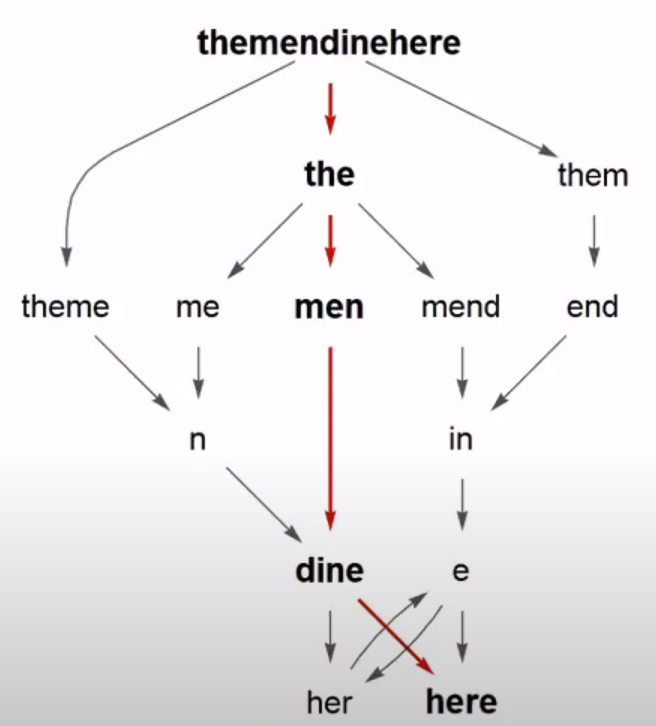

In [19]:
def maximal_by_reverse(string, words, return_amount=False):
    """
    4.1.2. Обратный алгоритм максимального соответствия
    
    --------------------
    string: входящая строка
    words: корпус слов
    return_amount: возвращать ли количество слов не в словаре
    """
    lowercaseCorpus = [x.lower() for x in words]
    tokens = []
    i = 0
    string = string[::-1]
    num_of_unknown_values = []
    while i < len(string):
        maxWord = ""
        for j in range(i, len(string)):
            tempWord = string[i:j+1][::-1]
            if tempWord in lowercaseCorpus and len(tempWord) > len(maxWord):
                maxWord = tempWord
           
        if maxWord == "":
            num_of_unknown_values.append(string[i])
            maxWord = string[i]
        i = i+len(maxWord)
        tokens.append(maxWord)
    if return_amount:
        return ' '.join(tokens[::-1]), num_of_unknown_values
    else:
        return ' '.join(tokens[::-1])

In [20]:
k = words.words()
k.remove('hemen')

In [21]:
maximal_by_reverse(s_eng, k)

'the men dine here'

In [23]:
maximal_by_reverse(string, russian_language_words_dict)

'вице премьер новая домашняя рыба'

In [27]:
maximal_by_reverse("новаявеличинарусскойпоэтическойкамы", russian_language_words_dict)

'новая величина русской по эти чес койка мы'

In [28]:
maximal_by("новаявеличинарусскойпоэтическойкамы", russian_language_words_dict)

'новая величина русской поэтической кам ы'

### 4.1.3. Двунаправленный алгоритм максимального соответствия

Двунаправленный алгоритм является комбинацией предыдущих алгоритмов. 

1. На первом шаге данного алгоритма выполняются прямой поиск, т.е. применяется алгоритм максимального соответствия и обратный поиск. 

2. Затем рассматриваются все полученные слова и выбирается наименее *сегментированная последовательность* (**с наименьшим количеством неизвестных слов**).

In [31]:
def two_ways(string, words):
    """
    4.1.3. Двунаправленный алгоритм максимального соответствия
    
    --------------------
    string: входящая строка
    words: корпус слов
    """
    w1, s1 = maximal_by(string, words, return_amount=True)
    w2, s2 = maximal_by_reverse(string, words, return_amount=True)
    if s1 > s2:
        return w2
    else:
        return w1

In [32]:
two_ways("новаявеличинарусскойпоэтическойкамы", russian_language_words_dict)

'новая величина русской поэтической кам ы'

In [33]:
two_ways(s_eng, k)

'theme n dine here'


### 4.1.4 Выделение подпоследовательности с наименьшим количеством слов

Указанный алгоритм рассматривает все возможные подпоследовательности и выбирает ту, где содержится наименьшее количество слов не из словаря. Ниже приведен пример реализации, где на каждом шаге из рассмотрения удаляются те ребра, по которым невозможна дальнейшая сегментация.

In [35]:
class TreeNode:
    def __init__(self, value, in_vocabulary=True, is_terminal=False):
        """
        Вершина дерева
        
        value - текущее разделение строки
        childrens - возможные разбиения слова
        in_vocabulary - слово есть в словаре
        is_terminal - вершина является листовой
        """
        self.value = value
        self.childrens = []
        self.in_vocabulary = in_vocabulary
        self.is_terminal = is_terminal

In [53]:
import collections
def dfs(start, visited=None):
    """
    Обход дерева в глубину. Возвращает список разбиений в терминальных вершинах.
    """
    if visited is None:
        visited = set()
    if start.is_terminal:
        visited.add(start.value)
    for next in set(start.childrens) - visited:
        dfs(next, visited)
    return visited

def bfs(root): 
    """
    Обход дерева в ширину. Возвращает список разбиений в терминальных вершинах.
    """
    visited, queue = set(), collections.deque([root])
    visited.add(root)
    m = []
    while queue: 
        vertex = queue.popleft()
        for neighbour in vertex.childrens: 
            visited.add(neighbour) 
            queue.append(neighbour)
            if neighbour.is_terminal:
                m.append(neighbour.value)
    return m

def maximal_by_rec(string, lowercaseCorpus, val=[], use_words_not_in_vocab=False):
    """
    4.1.4. Выделение подпоследовательности с наименьшим количеством слов
    
    --------------------
    string: входящая строка
    words: корпус слов
    val: родитель вершины
    use_words_not_in_vocab: использовать слова не из словаря при разбиении 
    """
    if val == []:
        node = TreeNode(value='')
    else:
        node = val
    i = 0
    if node.value == '':
        s = ''
    else:
        s = node.value + ' '
    for j in range(i, len(string)):
        tempWord = string[i:j+1]
        if string[len(tempWord):] != '':
            if tempWord in lowercaseCorpus:
                node.childrens.append(TreeNode(value=s + tempWord))
                maximal_by_rec(string[len(tempWord):], lowercaseCorpus, val=node.childrens[-1])
            else:
                node.childrens.append(TreeNode(value=s + tempWord, in_vocabulary=False))
                if use_words_not_in_vocab:
                    maximal_by_rec(string[len(tempWord):], lowercaseCorpus, val=node.childrens[-1])
        else:
            node.childrens.append(TreeNode(value=s + tempWord, is_terminal=True))
    return node

In [57]:
lowercaseCorpus = [x.lower() for x in russian_language_words_dict if len(x) != 1]

Выдаёт разбиение слов. Теперь с этими разбиениями можно делать что угодно.

In [62]:
bfs(maximal_by_rec("книгановаябызабрал", lowercaseCorpus, use_words_not_in_vocab=False))

['книгановаябызабрал',
 'кн игановаябызабрал',
 'книг ановаябызабрал',
 'книга новаябызабрал',
 'кн иг ановаябызабрал',
 'книг ан оваябызабрал',
 'книг ано ваябызабрал',
 'книга но ваябызабрал',
 'книга нова ябызабрал',
 'книга новая бызабрал',
 'кн иг ан оваябызабрал',
 'кн иг ано ваябызабрал',
 'книг ано ва ябызабрал',
 'книга но ва ябызабрал',
 'книга новая бы забрал',
 'кн иг ано ва ябызабрал',
 'книга новая бы за брал',
 'книга новая бы за бр ал',
 'книга новая бы за бра л']

Например, оценить вероятность подобного разделения, или взять с наименьшим количеством слов.

**Links**:

- [MaximumMatching](https://medium.com/@anshul16/maximum-matching-word-segmentation-algorithm-python-code-3444fe4bd6f9)